# Monte Carlo from Excel import

## Defining uncertain datasets in Excel

The Excel importer will automatically pick up the column labels that we use, so as long as we use columns that [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) will expect, we will be OK. As this is just an example, we can create a very simple inventory. Start by creating a new project.

In [1]:
%matplotlib inline

In [2]:
import stats_arrays as sa
import numpy as np
import matplotlib.pyplot as plt
import brightway2 as bw
import seaborn as sb

In [2]:
bw.projects.set_current("MC demo")

In [3]:
bw.bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[######                        ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/13/2019 15:55:51
  Finished: 05/13/2019 15:55:52
  Total time elapsed: 00:00:00
  CPU %: 82.20
  Memory %: 0.97
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.65 seconds
Wrote 850 LCIA methods with 220699 characterization factors
Creating core data migrations



Our inventory will have two processes; one will consume the other, and each will have one emission. We don't really care what they are, but they should be characterized by our LCIA method, so let's pick one at random and see which flows are characterized.

In [5]:
method = bw.methods.random()
method

('CML 2001', 'photochemical oxidation (summer smog)', 'high NOx POCP')

In [6]:
method = ('CML 2001', 'photochemical oxidation (summer smog)', 'high NOx POCP')

In [12]:
for key, cf in bw.Method(method).load()[20:30]:
    print(bw.get_activity(key), cf)

'2-Propanol' (kilogram, None, ('air', 'low population density, long-term')) 0.188
'2-Propanol' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')) 0.188
'2-Propanol' (kilogram, None, ('air', 'non-urban air or from high stacks')) 0.188
'2-Propanol' (kilogram, None, ('air',)) 0.188
'2-Propanol' (kilogram, None, ('air', 'urban air close to ground')) 0.188
'3-Methyl-1-butanol' (kilogram, None, ('air', 'low population density, long-term')) 0.433
'3-Methyl-1-butanol' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')) 0.433
'3-Methyl-1-butanol' (kilogram, None, ('air', 'non-urban air or from high stacks')) 0.433
'3-Methyl-1-butanol' (kilogram, None, ('air',)) 0.433
'3-Methyl-1-butanol' (kilogram, None, ('air', 'urban air close to ground')) 0.433


We can now create this basic inventory in Excel:

<img src="files/mc-simple-inventory.png">

## Importing the Excel worksheet

Download [the worksheet](https://bitbucket.org/cmutel/brightway2/raw/default/notebooks/files/basic_mc.xlsx) and put it in the same directory as this notebook.

In [44]:
ex = bw.ExcelImporter("basic_mc.xlsx")

Extracted 1 worksheets in 0.01 seconds


In [45]:
ex.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.41 seconds


In [46]:
ex.match_database(fields=['name'])

Applying strategy: link_iterable_by_fields


In [48]:
ex.write_database()

Writing activities to SQLite3 database:
0%  100%
[##] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 05/13/2019 16:29:40
  Finished: 05/13/2019 16:29:40
  Total time elapsed: 00:00:00
  CPU %: 105.90
  Memory %: 1.37
Created database: MC


## Do the Monte Carlo uncertainty analysis

The Monte Carlo class is an iterator, pretty easy to use.

In [53]:
mc = bw.MonteCarloLCA({("MC", "b"): 1}, method)
results = np.array([next(mc) for _ in range(10000)])

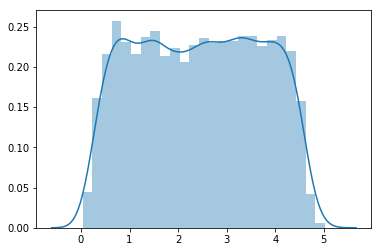

In [54]:
sb.distplot(results)

In [55]:
np.average(results), np.std(results)

(2.4336840852740265, 1.2640547320527133)

## Create graphs for figure

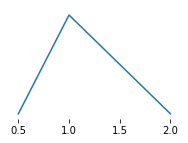

In [3]:
pa = sa.TriangularUncertainty.from_dicts({'minimum': 0.5, 'loc': 1, 'maximum': 2})
xs = np.linspace(0.5, 2, 100)
_, ys = sa.TriangularUncertainty.pdf(pa, xs)
plt.figure(figsize=(3, 2))
plt.yticks([])
plt.plot(xs, ys.ravel())
plt.box(None)
plt.savefig("A-B.png", dpi=300)

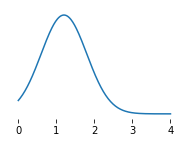

In [4]:
pa = sa.NormalUncertainty.from_dicts({'minimum': 0, 'loc': 1.2, 'maximum': 4, 'scale': 0.6})
xs = np.linspace(0, 4, 250)
_, ys = sa.NormalUncertainty.pdf(pa, xs)
plt.figure(figsize=(3, 2))
plt.yticks([])
plt.plot(xs, ys.ravel())
plt.box(None)
plt.savefig("A-P.png", dpi=300)

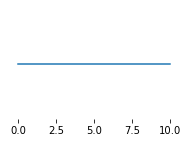

In [5]:
pa = sa.UniformUncertainty.from_dicts({'minimum': 0, 'maximum': 10})
xs = np.linspace(0, 10, 100)
_, ys = sa.UniformUncertainty.pdf(pa, xs)
plt.figure(figsize=(3, 2))
plt.yticks([])
plt.plot(xs, ys.ravel())
plt.box(None)
plt.savefig("B-M.png", dpi=300)

In [6]:
np.random.random(size=10)

array([0.87842036, 0.29114001, 0.16272555, 0.57319773, 0.11849179,
       0.11692833, 0.92526059, 0.12608184, 0.16824371, 0.90003393])